In [1]:
import math
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from scipy import signal, fftpack, stats

In [2]:
# Retrieve folders for transgenic strains

transgenics = os.listdir('CoBar-Dataset')
transgenics.remove('PR') # Control

In [3]:
def load_data(xp):
    # Load gendict
    genDict = np.load(f'CoBar-Dataset/{xp}/U3_f/genotype_dict.npy', allow_pickle=True).item()
    
    # Load data
    with open(f'CoBar-Dataset/{xp}/U3_f/{xp}_U3_f_trackingData.pkl', 'rb') as f:
        data = pickle.load(f)
    
    print(f'{xp} - Data dimension: {data.shape}')
    
    # Extract metadata
    metadata = np.array([list(item) for item in data.index.values])
    print(f'{xp} - Metadata dimension: {metadata.shape}')
    
    return genDict, data, metadata

In [4]:
def get_data_per_fly_per_xp():   
    dict_pretarsi_data = {}
    dict_metadata = {}
    dict_pos_data = {}
    
    stim_col = 1 # Metadata column with stimulation info ('on'/'off')
    xp_col = 3   # Metadata column with experiment info (time of experiment)
    fly_col = 4  # Metadata column with fly info (fly 0, 1 or 2) 
    
    for strain in transgenics:
        # Load data for given strain
        genDict, data, metadata = load_data(strain)
        
        # Extract pretarsi data
        pretarsi = ["LFclaw", "LHclaw", "LMclaw", "RFclaw", "RHclaw", "RMclaw"]
        pos = ["posx", "posy"]
        orientation = ["orientation"]
        pretarsi_data = data[pretarsi]   
        pos_data = data["center"][pos + orientation]
    
        # Gather all possible experiments and maximum number of flies
        xps = np.unique(metadata[:,xp_col])
        flies = np.unique(metadata[:,fly_col])
        
        n_trials = len(xps)*len(flies)

        for xp in xps:
            # Extract rows corresponding to current experiment
            xp_idx = np.where(metadata[:,xp_col] == xp)[0]
            
            # Extract corresponding metadata, pretarsi data and positional data
            xp_metadata = metadata[xp_idx]
            xp_pretarsi_data = pretarsi_data.iloc[xp_idx]
            xp_pos_data = pos_data.iloc[xp_idx]

            for fly in flies:
                # Extract rows corresponding to current fly
                fly_idx = np.where(xp_metadata[:,fly_col] == fly)[0]
                
                # Extract corresponding metadata and data for current fly
                xp_fly_metadata = xp_metadata[fly_idx]
                xp_fly_pretarsi_data = xp_pretarsi_data.iloc[fly_idx]
                xp_fly_pos_data = xp_pos_data.iloc[fly_idx]
                
                xp_fly_metadata = np.append(xp_fly_metadata, np.array(range(len(xp_fly_metadata))).reshape(-1,1), axis=1)
                
                
                # Sort timestamps, and re-arrange fly data for time stamps
                # Order = 'off0', 'on0', 'off1', 'on1', 'off2', 'on2', 'off3'
                if not(xp_fly_pretarsi_data.empty):
                    
                    dict_metadata[xp+fly] = np.array(sorted(xp_fly_metadata, key=lambda x: (int(x[stim_col][-1]), x[stim_col])))
                    idx_sort = np.array(list(map(int, dict_metadata[xp+fly][:,-1])))
                    dict_pretarsi_data[xp + fly] = np.array(xp_fly_pretarsi_data)[idx_sort,:] * 38/832                    
                    dict_pos_data[xp + fly] = np.array(xp_fly_pos_data)[idx_sort,:]
                    
                    # Only convert x, y pos positions to mm
                    dict_pos_data[xp + fly][:,:2] *= 38/832
                else:
                    n_trials -= 1
        
        print(f'{strain}: {n_trials} trials')
    
    return dict_pretarsi_data, dict_metadata, dict_pos_data

In [5]:
raw_pretarsi_data, raw_metadata, raw_pos_data = get_data_per_fly_per_xp()

MDN - Data dimension: (28770, 70)
MDN - Metadata dimension: (28770, 6)
MDN: 12 trials
SS01049 - Data dimension: (26385, 70)
SS01049 - Metadata dimension: (26385, 6)
SS01049: 11 trials
SS01054 - Data dimension: (31162, 70)
SS01054 - Metadata dimension: (31162, 6)
SS01054: 13 trials
SS01540 - Data dimension: (26361, 70)
SS01540 - Metadata dimension: (26361, 6)
SS01540: 11 trials
SS02111 - Data dimension: (26396, 70)
SS02111 - Metadata dimension: (26396, 6)
SS02111: 11 trials
SS02279 - Data dimension: (28776, 70)
SS02279 - Metadata dimension: (28776, 6)
SS02279: 12 trials
SS02377 - Data dimension: (28764, 70)
SS02377 - Metadata dimension: (28764, 6)
SS02377: 12 trials
SS02608 - Data dimension: (28740, 70)
SS02608 - Metadata dimension: (28740, 6)
SS02608: 12 trials
SS02617 - Data dimension: (26355, 70)
SS02617 - Metadata dimension: (26355, 6)
SS02617: 11 trials


In [6]:
#raw_metadata.keys()
mdn = '200206_1539540'
turn = '200212_1620432'

In [7]:
def adjust_angular_displacement(dtheta):
    for i in range(len(dtheta)):
        if np.abs(dtheta[i]) > 300:
            dtheta[i] = 360 - np.abs(dtheta[i])
    return dtheta

def pos2vel(x, fps=80, angular=False):
    '''
    Convert positions to velocities, and apply moving-average filter
    '''
    dx = np.array([0] + [x[i] - x[i-1] for i in range(1, len(x))])
    
    # Adjust angular displacements if we are computing angular velocities
    if angular:
        dx = adjust_angular_displacement(dx)
        # Convert to radians
        dx *= np.pi/180
    return SMA(dx*fps)
    
def cart2pol(x,y):
    '''
    Convert Cartesian to Polar coordinates
    '''
    rho = np.sqrt(x**2+y**2)
    phi = np.arctan2(y, x)*180/np.pi
    return (rho, phi)

def SMA(x, window=5):
    '''
    Moving-average with convolution
    '''
    return np.convolve(x, np.ones((window,))/window, mode='same')

def findOnPeriods(key, raw_metadata, display=False):
    metadata = raw_metadata[key]
    on_periods = ['on0', 'on1', 'on2']

    on_intervals = []

    for p in on_periods:
        start_period = np.where(metadata[:,1] == p)[0][0]
        end_period = np.where(metadata[:,1] == p)[0][-1]
        on_intervals.append(list(range(start_period, end_period)))
        if display:
            print(f'{p}: {[start_period, end_period]}')
    return on_intervals

def intersect(list1, list2):
    return [x for x in list1 if x in list2]

def findFlyDirections(theta, theta_eff):
    direction = np.zeros_like(theta_eff)

    for n in range(len(theta)):
        if 90 <= theta[n] <= 270:
            if (theta[n] - 90) < (theta_eff[n] % 360) <= (theta[n] + 90):
                direction[n] = 1
            else:
                direction[n] = -1

        elif theta[n] < 90 :
            if (theta[n] - 90) < theta_eff[n] <= (theta[n] + 90):
                direction[n] = 1
            else:
                direction[n] = -1

        else:
            if (theta[n] - 360 - 90) < theta_eff[n] <= ((theta[n] + 90) % 360):
                direction[n] = 1
            else:
                direction[n] = -1
    return direction

In [9]:
test_pos = raw_pos_data[turn]

In [10]:
x, y, theta = test_pos[:,0], test_pos[:,1], test_pos[:,2]
vx, vy, vtheta = pos2vel(x), pos2vel(y), pos2vel(theta, angular=True)

rho, phi = cart2pol(x, y)
vrho, _ = cart2pol(vx, vy)

theta_eff = np.arctan2(vx, -vy)*180/np.pi

direction = findFlyDirections(theta, theta_eff)

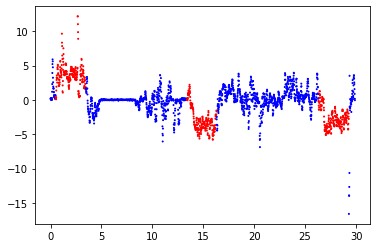

In [12]:
on_periods = findOnPeriods(turn, raw_metadata)
on_periods_flat = [frame for sub_on in on_periods for frame in sub_on]

plt.scatter(np.array(range(len(vrho)))/80, vtheta,
            c = ['r' if x in on_periods_flat else 'b' for x in range(len(vrho))],
            s = 1)
plt.show()

In [13]:
def findStationaryIndices(key, raw_pos_data, raw_metdata):
    '''
    Exclude frames with stationary flies during off-periods
    '''
    
    stim_col = 1
    
    # Load positional data and corresponding metadata
    pos_data, metadata = raw_pos_data[key], raw_metadata[key]
    
    x, y, theta = pos_data[:,0], pos_data[:,1], pos_data[:,2]
    vx, vy, vtheta = pos2vel(x), pos2vel(y), pos2vel(theta, angular=True)
    
    vrho, _ = cart2pol(vx, vy)
    
    return np.where((['off' in stim for stim in metadata[:,1]]) & (vrho < 1) & (np.abs(vtheta) < 2))[0]

def get_velocities_per_fly_per_xp(raw_pretarsi_data, raw_metadata, raw_pos_data):
    '''
    Extract velocity data from positional data for each fly.
    
    For each fly, find v_forward (v_y ?), v_lateral (v_x ?), v_rotational (v_phi ?)
    '''
    
    motion_data = {}
    velocity_data = {}
    velocity_metadata = {}

    N_legs = 6 # 6 tarsi/pretarsi
    N_vels = 3 # v_x, v_y and v_phi

    for key, data in raw_pretarsi_data.items():
        N_frames = data.shape[0]
        
        stationary_idxs = findStationaryIndices(key, raw_pos_data, raw_metadata)        
        motion_idxs = np.delete(np.arange(N_frames), stationary_idxs)
        
        velocity_fly_data = np.zeros((len(motion_idxs), N_legs, N_vels))
        
        motion_fly_data = data[motion_idxs,:]

        for pretarsus_idx, data_idx in enumerate(range(0, motion_fly_data.shape[1], 2)):
            # Pretarsus_idx in [0, 5] for each pretarsus
            # Data_idx = [0, 2, 4, 6, 8, 10] for index of x-position of each pretarsus
            x, y = motion_fly_data[:,data_idx], motion_fly_data[:, data_idx+1]
            
            # Convert x, y positions to polar to extract angular position
            _, phi = cart2pol(x, y) 
            
            # Find velocities from positional data
            v_x, v_y, v_phi = pos2vel(x), pos2vel(y), pos2vel(phi, angular=True)

            velocity_fly_data[:, pretarsus_idx, :] = np.stack((v_x, v_y, v_phi), axis=1)

        #print(len(velocity_fly_data))
        motion_data[key] = motion_fly_data
        velocity_metadata[key] = raw_metadata[key][motion_idxs,:]
        velocity_data[key] = velocity_fly_data
    
    return velocity_data, velocity_metadata, motion_data

In [14]:
velocity_data, velocity_metadata, motion_data = get_velocities_per_fly_per_xp(raw_pretarsi_data, raw_metadata, raw_pos_data)

In [15]:
#on_periods = findOnPeriods(mdn, raw_metadata, display=True)
on_periods = findOnPeriods(mdn, velocity_metadata, display=True)

on0: [37, 276]
on1: [879, 1118]
on2: [1537, 1774]


(2400, 12)


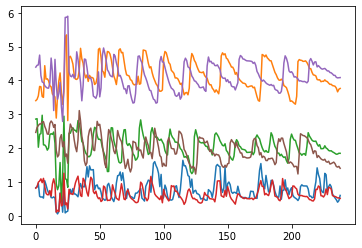

In [16]:
# Print positional data
test = raw_pretarsi_data[mdn] # Example positional data for one fly in one xp
test_metadata = raw_metadata[mdn]
print(test.shape)

for y in range(1,test.shape[1], 2):
    plt.plot(test[:,y][41:280])
plt.show()

(1778, 7)
(1778, 6, 3)


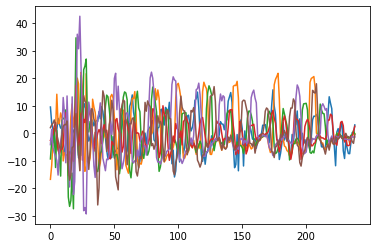

In [17]:
# Print velocity data

test_velocity = velocity_data[mdn] # Example velocity data for one fly in one xp
test_meta_velocity = velocity_metadata[mdn]

print(test_meta_velocity.shape)
print(test_velocity.shape)

for i in range(test_velocity.shape[1]):
    v_l = test_velocity[:,i,0][37:276] # v_x
    v_f = test_velocity[:,i,1][37:276] # v_y
    v_r = test_velocity[:,i,2][37:276] # v_phi
    plt.plot(v_f)
plt.show()